In [53]:
import numpy as np
import pandas as pd
import os
from fitness import get_fitness
from models.Kriging import Kriging
from models.PR import Polynomial_Regression as PR
# from models.RBF import Model as RBF

In [54]:
#Curve Road
data_folders = [
    # '../data/routes_short_2023-05-12|17:04:09/', #814
    # '../data/routes_short_2023-05-26|17:51:48/', #721
    '../data/routes_short_2023-06-06|18:33:36/', #916 95% Route Finish Threshold
    '../data/routes_short_2023-06-07|14:26:32/', #727 95% Route Finish Threshold
]

In [55]:
scenario_header = ["cloudiness",
                   "precipitation",
                   "precipitation_deposits",
                   "wind_intensity",
                   "sun_azimuth_angle",
                   "sun_altitude_angle",
                   "fog_density",
                   "wetness",
                   "fog_falloff",
                   "vehicle_infront", 
                   "vehicle_opposite", 
                   "vehicle_side",
                   "start_offset",
                   "end_offset"]

scenarios = pd.read_csv(data_folders[0]+'scenario.csv',names=scenario_header)
for i in range(1, len(data_folders)):
    scenarios = pd.concat([scenarios, pd.read_csv(data_folders[i]+'scenario.csv',names=scenario_header)])
print(scenarios.shape)

(1635, 14)


In [56]:
select_criterions = ["RouteCompletionTest", 
                     "CollisionTest", 
                     "OutsideRouteLanesTest", 
                     "Timeout"]

fitness = get_fitness(data_folders[0])
for i in range(1, len(data_folders)):
    fitness = pd.concat([fitness, get_fitness(data_folders[i])])

fitness = fitness[select_criterions]
print(fitness.shape)

(1635, 4)


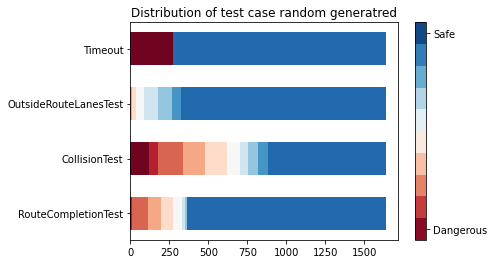

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap = mpl.cm.RdBu
colors = cmap(range(3,253,25))

stack_hist_continuous = np.concatenate([
    [np.histogram(fitness['RouteCompletionTest'],   range=(0,1), bins=10)[0]],
    [np.histogram(fitness['CollisionTest'],         range=(0,1), bins=10)[0]],
    [np.histogram(fitness['OutsideRouteLanesTest'], range=(0,1), bins=10)[0]],
    [np.histogram(fitness['Timeout'],               range=(0,1), bins=10)[0]],
])

left = np.zeros(4)
for i in range(10):
    plt.barh(y = np.arange(4), width = stack_hist_continuous[:,i], left=left, color = colors[i], height=0.6)
    left += stack_hist_continuous[:,i]

plt.yticks(range(4), select_criterions)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ticklocation='right',values=range(10), ticks=[0, 9])
cbar.ax.set_yticklabels(['Dangerous', 'Safe'])  # vertically oriented colorbar

plt.title('Distribution of test case random generatred')
plt.show()

In [50]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import joblib
seed = 42

certion_label = "RouteCompletionTest"
X = scenarios.to_numpy()
y = fitness[certion_label].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

rgs = RandomForestRegressor(max_depth=7, criterion='friedman_mse', random_state=seed)
# rgs = HistGradientBoostingRegressor()
rgs.fit(X_train, y_train)

# rgs = PR(data=X_train, label=y_train, degree=2)
# rgs = Kriging(data=X_train, label=y_train)

res = rgs.predict(X_train)
# res = rgs.pol_reg.predict(rgs.poly_reg.fit_transform(X_test))
res[res>1]=1
res[res<0]=0

print(explained_variance_score(y_train, res)) 
print(np.corrcoef(y_train, res)[0,1])


res = rgs.predict(X_test)
# res = rgs.pol_reg.predict(rgs.poly_reg.fit_transform(X_test))
res[res>1]=1
res[res<0]=0

print(explained_variance_score(y_test, res).round(3)) 
print(np.corrcoef(y_test, res)[0,1].round(3))

0.8529474492921119
0.935016716789923
0.495
0.705


max_depth: 1
                      | Train EVS | Test EVS
---------------------------------------------
  RouteCompletionTest |  1.00000  |  -0.03653 
        CollisionTest |  1.00000  |  0.39059 
OutsideRouteLanesTest |  1.00000  |  0.11582 
              Timeout |  1.00000  |  -0.21292 
---------------------------------------------
                  SUM |  1.00000  |  0.06424 




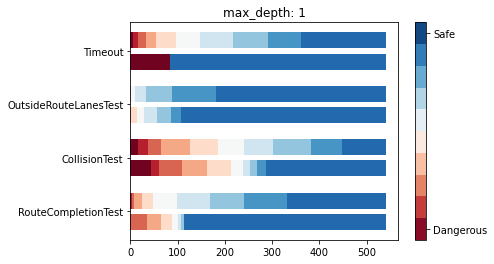

In [63]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import joblib

seed = 42

max_f1_sum = 0
# for depth in range(1,30,3):
for depth in range(1,2):

    print("max_depth:",depth)
    print("                      | Train EVS | Test EVS")
    print("---------------------------------------------")
    res_sum = [0,0]
    stack_hist_pred = []
    stack_hist_test = []
    for certion_label in ["RouteCompletionTest", "CollisionTest", "OutsideRouteLanesTest", "Timeout"]:
        X = scenarios.to_numpy()
        y = fitness[certion_label].to_numpy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

        # rgs = RandomForestRegressor(max_depth=7, criterion='friedman_mse', random_state=seed)
        # rgs = HistGradientBoostingRegressor()
        # rgs.fit(X_train, y_train)

        # rgs = PR(data=X_train, label=y_train, degree=2)
        rgs = Kriging(data=X_train, label=y_train)

        pred_train = rgs.predict(X_train)
        pred_test  = rgs.predict(X_test)
        pred_train[pred_train>1] = 1
        pred_train[pred_train<0] = 0
        pred_test[pred_test>1] = 1
        pred_test[pred_test<0] = 0

        train_score = explained_variance_score(y_train, pred_train) 
        test_score = explained_variance_score(y_test, pred_test) 
        # train_score = (sum(pred_train - y_train)**2/y_train.shape[0])**0.5
        # test_score = (sum(pred_test - y_test)**2/y_test.shape[0])**0.5

        print("{:>21} |  {:0<7}  |  {:0<7} ".format(
            certion_label,
            round(train_score, 5), 
            round(test_score, 5)
        ))

        if certion_label == 'RouteCompletionTest':
            stack_hist_pred = np.array([np.histogram(pred_test, range=(0,1), bins=10)[0]])
            stack_hist_test = np.array([np.histogram(y_test, range=(0,1), bins=10)[0]])
        else:
            stack_hist_pred = np.concatenate([stack_hist_pred, [np.histogram(pred_test, range=(0,1), bins=10)[0]]])
            stack_hist_test = np.concatenate([stack_hist_test, [np.histogram(y_test, range=(0,1), bins=10)[0]]])
        # print(rfr.predict(X_test))
        # joblib.dump(clf, 'models/RF-{}.pkl'.format(certion_label))


        res_sum[0] = res_sum[0] + train_score
        res_sum[1] = res_sum[1] + test_score
    print("---------------------------------------------")
    print("                  SUM |  {:0<7}  |  {:0<7} ".format(round(res_sum[0]/4,5), round(res_sum[1]/4,5)))
    print()
    print()

    left = np.zeros(4)
    for i in range(10):
        plt.barh(y = np.arange(4)+0.2, width = stack_hist_pred[:,i], left=left, color = colors[i], height=0.3)
        left += stack_hist_pred[:,i]

    left = np.zeros(4)
    for i in range(10):
        plt.barh(y = np.arange(4)-0.2, width = stack_hist_test[:,i], left=left, color = colors[i], height=0.3)
        left += stack_hist_test[:,i]


    plt.yticks(range(4), select_criterions)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ticklocation='right',values=range(10), ticks=[0, 9])
    cbar.ax.set_yticklabels(['Dangerous', 'Safe'])  # vertically oriented colorbar

    plt.title("max_depth: {}".format(depth))
    plt.show()


In [64]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import joblib

seed = 42

max_f1_sum = 0

i = 1

for certion_label in ["RouteCompletionTest", "CollisionTest", "OutsideRouteLanesTest", "Timeout"]:
    X = scenarios.to_numpy()
    y = fitness[certion_label].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

    # rgs = RandomForestRegressor(max_depth=i, random_state=seed)
    # rgs = HistGradientBoostingRegressor()
    # rgs.fit(X_train, y_train)

    # rgs = PR(data=X_train, label=y_train, degree=2)
    rgs = Kriging(data=X_train, label=y_train)


    joblib.dump(rgs, 'models/regression-Kriging-{}.pkl'.format(certion_label))

In [65]:
model_path = '../tools/models/regression-'
surrogate_models = {"RouteCompletionTest"  : joblib.load(model_path+'Kriging-RouteCompletionTest.pkl'), 
                    "CollisionTest"        : joblib.load(model_path+'Kriging-CollisionTest.pkl'), 
                    "OutsideRouteLanesTest": joblib.load(model_path+'Kriging-OutsideRouteLanesTest.pkl'), 
                    "Timeout"              : joblib.load(model_path+'Kriging-Timeout.pkl')}

X = scenarios.to_numpy()
y = fitness[certion_label].to_numpy()
